<a href="https://colab.research.google.com/github/SantiagoGomezfpv/hyperparameter/blob/main/CNN_1D_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optuna CNN 1D

En este notebook, entrenaremos y optimizaremos una red neuronal convolucional 1D (CNN1D) para la clasificación de señales temporales utilizando el conjunto de datos **FordA**. El objetivo es encontrar la mejor configuración de hiperparámetros para maximizar la precisión del modelo mediante la biblioteca de optimización Optuna. Los hiperparámetros se ajustan a través de un proceso de búsqueda de hiperparámetros en varias configuraciones, con un enfoque en maximizar el rendimiento del modelo.

## Primero, realizamos las instalaciones necesarias:

In [1]:
!pip install optuna scikit-learn xgboost matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


## Segundo, importamos las bibliotecas necesarias:

In [2]:
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import urllib.request
import os

## Conjunto de Datos
El conjunto de datos **FordA** proviene del UCR Time Series Classification Archive y contiene datos de series temporales de un problema de diagnóstico de motores. Se compone de dos clases: 0 y 1, representando la condición del motor. Cada muestra es una secuencia de 500 puntos que corresponden a una señal temporal de voltaje. En este notebook, descargaremos y preprocesaremos los datos, y convertiremos las etiquetas a un formato binario (0 y 1).

## Preprocesamiento de Datos:
* **Descarga de los Datos:** Los archivos de entrenamiento y prueba se descargan desde el repositorio público.
* **Separación de Características y Etiquetas:** Las características corresponden a los valores de la serie temporal, y las etiquetas representan la clase.
* **Conversión de Etiquetas:** Se ajustan las etiquetas de -1 y 1 a 0 y 1, respectivamente, para una clasificación binaria.
* **División en Entrenamiento y Validación:** Separamos el conjunto de datos de entrenamiento en dos subconjuntos: entrenamiento y validación, para evaluar el modelo.
* **Normalización:** Se utiliza un escalador estándar para normalizar los datos, de manera que cada característica tenga media cero y desviación estándar uno.


In [3]:
# Descargar los archivos de FordA directamente
train_data_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TRAIN.tsv"
test_data_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/FordA_TEST.tsv"

train_data_path = "FordA_TRAIN.tsv"
test_data_path = "FordA_TEST.tsv"

if not os.path.exists(train_data_path):
    urllib.request.urlretrieve(train_data_url, train_data_path)

if not os.path.exists(test_data_path):
    urllib.request.urlretrieve(test_data_url, test_data_path)

# Cargar los datos
train_data = np.loadtxt(train_data_path)
test_data = np.loadtxt(test_data_path)

# Separar características y etiquetas
X_train = train_data[:, 1:]
y_train = train_data[:, 0].astype(int)
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

# Convertir las etiquetas de -1 y 1 a 0 y 1 para la clasificación binaria
y_train = np.where(y_train == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_ai_train, X_ai_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_ai_train = scaler.fit_transform(X_ai_train)
X_ai_val = scaler.transform(X_ai_val)
X_ai_test = scaler.transform(X_test)

# Convertir los datos a tensores y asegurar que las etiquetas sean 1D
X_ai_train = torch.tensor(X_ai_train, dtype=torch.float32)
y_train = torch.tensor(y_train.squeeze(), dtype=torch.long)
X_ai_val = torch.tensor(X_ai_val, dtype=torch.float32)
y_val = torch.tensor(y_val.squeeze(), dtype=torch.long)
X_ai_test = torch.tensor(X_ai_test, dtype=torch.float32)
y_test = torch.tensor(y_test.squeeze(), dtype=torch.long)

# Definir el dispositivo como CUDA si está disponible, de lo contrario usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Arquitectura del Modelo CNN1D
La red se define de manera flexible para adaptarse a las configuraciones propuestas por Optuna:

* **Número de Capas Convolucionales (num_conv_layers):** Se optimiza entre 2 y 4 capas.
* **Número de Filtros (num_filter_i):** El número de filtros de cada capa se optimiza en un rango de 16 a 512 en pasos de 16.
* **Neuronas en la Capa Oculta (num_neurons):** Número de neuronas en la capa densa intermedia, optimizado en un rango de 10 a 400 en pasos de 10.
* **Dropout en la Segunda Capa Convolucional (drop_conv2):** Valor de dropout para evitar sobreajuste, optimizado entre 0.2 y 0.5.
* **Dropout en la Capa Oculta (drop_fc1):** Dropout aplicado a la capa totalmente conectada, con un rango de 0.2 a 0.5.

## Optimización de Hiperparámetros con Optuna
Para encontrar la mejor configuración, Optuna optimiza los siguientes hiperparámetros:

* **Optimizador (optimizer):** Se elige entre Adam, RMSprop y SGD.
* **Tasa de Aprendizaje (lr):** Se ajusta en un rango logarítmico de 0.001 a 0.1.
* **Número de Capas Convolucionales (num_conv_layers):** De 2 a 4 capas.
* **Número de Filtros en Cada Capa (num_filter_i):** Rango de 16 a 512 con incrementos de 16.
* **Número de Neuronas en la Capa Oculta (num_neurons):** Rango de 10 a 400 en incrementos de 10.
* **Dropout en la Segunda Capa Convolucional (drop_conv2) y la Capa Oculta (drop_fc1):** Rango de 0.2 a 0.5.

El objetivo de la optimización es maximizar la precisión de clasificación en el conjunto de validación.

## Evaluación del Modelo
Después de optimizar el modelo, se entrena con los mejores hiperparámetros en el conjunto de entrenamiento completo y se evalúa tanto en el conjunto de validación como en el de prueba. Las métricas de evaluación incluyen:

Reporte de Clasificación: Precisión, recall y F1-score para cada clase.
Matriz de Confusión: Visualización de los errores de clasificación.


[I 2024-10-22 02:29:09,941] A new study created in memory with name: no-name-86f898c1-9a8d-455f-9487-a900fb242cdb
[I 2024-10-22 02:29:15,413] Trial 0 finished with value: 0.521497919556172 and parameters: {'num_conv_layers': 2, 'num_filter_0': 480.0, 'num_filter_1': 48.0, 'num_neurons': 280, 'drop_conv2': 0.2756005691670151, 'drop_fc1': 0.23984592798956944, 'optimizer': 'SGD', 'lr': 0.01445455476624703}. Best is trial 0 with value: 0.521497919556172.
[I 2024-10-22 02:29:16,637] Trial 1 finished with value: 0.4868238557558946 and parameters: {'num_conv_layers': 4, 'num_filter_0': 144.0, 'num_filter_1': 192.0, 'num_filter_2': 480.0, 'num_filter_3': 80.0, 'num_neurons': 200, 'drop_conv2': 0.3791296250512185, 'drop_fc1': 0.4991689444693655, 'optimizer': 'Adam', 'lr': 0.01312001180500862}. Best is trial 0 with value: 0.521497919556172.
[I 2024-10-22 02:29:17,608] Trial 2 finished with value: 0.5117891816920943 and parameters: {'num_conv_layers': 3, 'num_filter_0': 32.0, 'num_filter_1': 432.

Mejores hiperparámetros: {'num_conv_layers': 2, 'num_filter_0': 16.0, 'num_filter_1': 288.0, 'num_neurons': 210, 'drop_conv2': 0.44735583272336427, 'drop_fc1': 0.48892539578953437, 'optimizer': 'Adam', 'lr': 0.0027742439282391067}
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       373
           1       0.89      0.65      0.75       348

    accuracy                           0.79       721
   macro avg       0.81      0.79      0.79       721
weighted avg       0.81      0.79      0.79       721



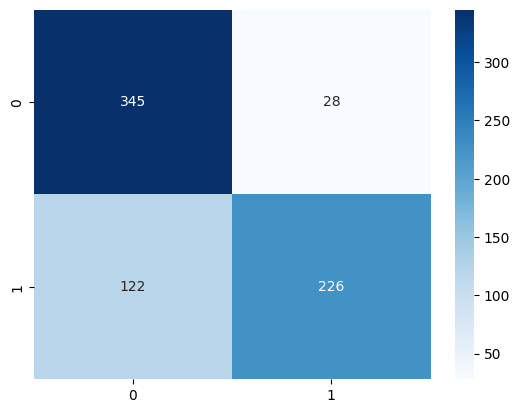

Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       681
           1       0.92      0.68      0.78       639

    accuracy                           0.82      1320
   macro avg       0.84      0.81      0.81      1320
weighted avg       0.84      0.82      0.81      1320



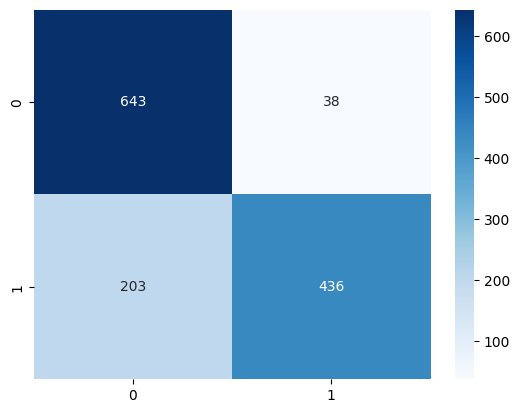

In [4]:
# Definición de la CNN 1D
class Net(nn.Module):
    def __init__(self, trial, input_length):
        super(Net, self).__init__()
        num_conv_layers = trial.suggest_int("num_conv_layers", 2, 4)
        num_filters = [int(trial.suggest_float("num_filter_" + str(i), 16, 512, step=16)) for i in range(num_conv_layers)]
        num_neurons = trial.suggest_int("num_neurons", 10, 400, step=10)
        drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)
        drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)

        self.convs = nn.ModuleList()
        in_channels = 1
        self.pool = nn.MaxPool1d(2)

        for i, out_channels in enumerate(num_filters):
            self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1))
            self.convs.append(nn.ReLU())
            self.convs.append(self.pool)
            in_channels = out_channels
            if i == 1:  # Aplicar dropout después de la segunda capa convolucional
                self.convs.append(nn.Dropout(drop_conv2))

        # Calcular la longitud de la secuencia después de las capas convolucionales y de pooling
        conv_output_size = input_length
        for _ in range(num_conv_layers):
            conv_output_size = (conv_output_size - 3 + 2 * 1) // 1 + 1
            conv_output_size = int(conv_output_size / 2)

        self.fc1 = nn.Linear(num_filters[-1] * conv_output_size, num_neurons)
        self.drop_fc1 = nn.Dropout(drop_fc1)
        self.fc2 = nn.Linear(num_neurons, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        for layer in self.convs:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc1(x)
        x = self.fc2(x)
        return x

# Función objetivo para Optuna
def objective(trial):
    # Crear datasets y dataloaders
    train_dataset = TensorDataset(X_ai_train, y_train)
    val_dataset = TensorDataset(X_ai_val, y_val)
    test_dataset = TensorDataset(X_ai_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    input_length = X_ai_train.shape[1]
    model = Net(trial, input_length).to(device)

    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Entrenamiento de la red
    model.train()
    for epoch in range(2):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

    # Validación de la red
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    return accuracy

# Crear un estudio de Optuna y encontrar los mejores hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Evaluar el modelo
def evaluate_model(model, dataloader, y_true):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
    y_pred = np.array(y_pred)
    print(classification_report(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.show()

# Entrenar el mejor modelo en el conjunto de entrenamiento completo
best_trial = study.best_trial
input_length = X_ai_train.shape[1]
best_model = Net(best_trial, input_length).to(device)
optimizer_name = best_trial.params['optimizer']
lr = best_trial.params['lr']
optimizer = getattr(optim, optimizer_name)(best_model.parameters(), lr=lr)

# Crear dataloaders completos
train_loader = DataLoader(TensorDataset(X_ai_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_ai_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_ai_test, y_test), batch_size=64, shuffle=False)

# Entrenar el modelo con los mejores hiperparámetros
best_model.train()
for epoch in range(5):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = best_model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# Evaluación en conjunto de validación
print("Validation Classification Report:")
evaluate_model(best_model, val_loader, y_val)

# Evaluación en conjunto de prueba
print("Test Classification Report:")
evaluate_model(best_model, test_loader, y_test)

# Visualización de los Resultados
Optuna proporciona herramientas de visualización para entender mejor los resultados de la optimización. Agregamos visualizaciones para ver la historia de la optimización, las coordenadas paralelas y la importancia de los parámetros.

* **plot_optimization_history:** Muestra cómo ha cambiado el valor objetivo a lo largo de los ensayos.
* **plot_parallel_coordinate:** Muestra las relaciones entre los parámetros y el valor objetivo.
* **plot_param_importances:** Muestra la importancia relativa de cada parámetro.

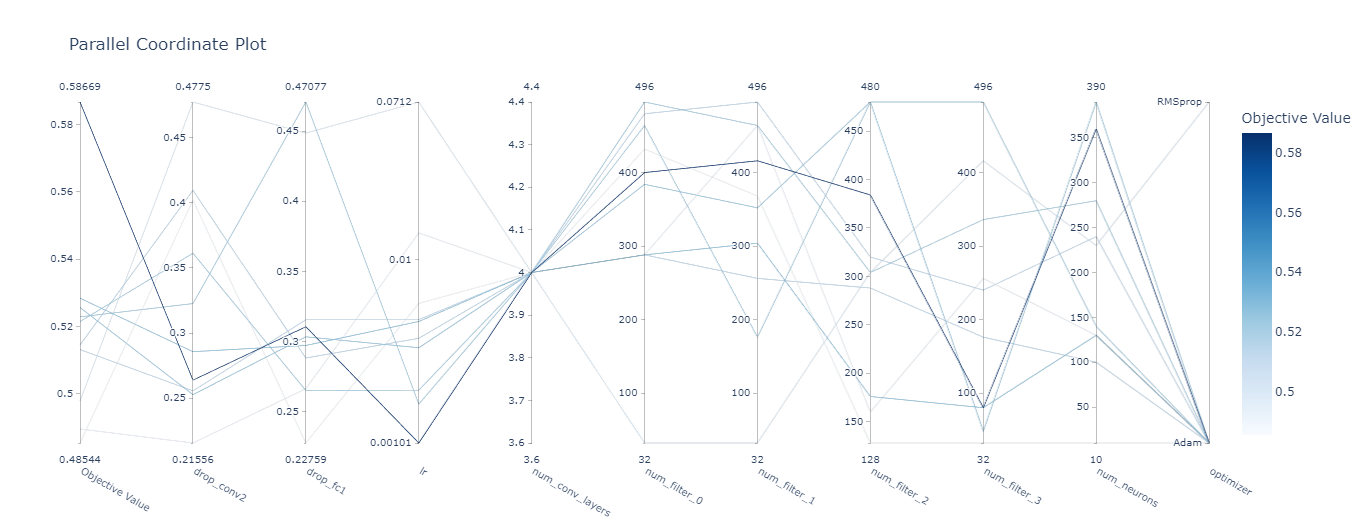

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)